### 2021 Spring "EE479: Scientific Computing & Data"
#### Yong-Hoon Kim, KAIST Electrical Engineering
#### Kutz 8.5 Overcoming Computational Difficulties
##### Writer: Yumin Song

###### 2021. 05. 16 revised

#### Streamfunction equations: Nonuniqueness

We return to the consideration of the streamfunction equation 

 $$ \nabla^2\psi = \omega  $$  

with the periodic boundary conditions

$$ \psi(-L,y) = \psi(L,y) $$
$$ \psi(x,-L) = \psi(x,L) $$

In this equation, the solution can only be determined to an arbitrary constant. Thus if $\psi_{0}$ is a
solution to the streamfunction equation, so is

$$ \psi = \psi_{0} + c  $$

where $ c $ is an arbitrary constant. This gives an infinite number of solutions to the problem. We find that the matrix $A$, which is singular

Obviously, the fact that the matrix $A$ is singular will create computational problems. To overcome this problem numerically, we simply observe that we can arbitrarily add a constant to the solution. Or alternatively, we can pin down the value of the streamfunction at a single location in the computational domain. This constraint fixes the arbitrary constant problem and removes the singularity from the matrix $A$. Thus to fix the problem, we can simply pick an arbitrary point in our computational domain $\psi_{mn}$ and fix its value.
We simply add this property by adding following line

$A[0,0] = 0 $

Note that the choice of the matrix component and its value are completely arbitrary.

Size of A matrix = 2500


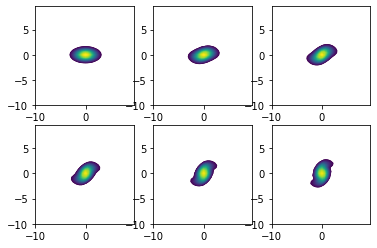

In [7]:
import numpy as np
import scipy.sparse.linalg as linag
import time
import matplotlib.pyplot as plt
from scipy.linalg import lu_factor, lu_solve

N=2500
########################################### A Matrix construct 
I2 = -4*np.eye(N)
E = np.diag(np.ones((N-1)), k=1)
E2 = np.diag( np.ones(int(np.sqrt(N))), N-int(np.sqrt(N))  )
E3 = np.diag( np.ones(N-int(np.sqrt(N))), int(np.sqrt(N))  )
A = I2 + E + E.T +E2 + E2.T + E3 + E3.T
for i in range(int(np.sqrt(N))):
    A[(i+1)*int(np.sqrt(N))-1,int(np.sqrt(N))*i] = 1
    A[int(np.sqrt(N))*i,(i+1)*int(np.sqrt(N))-1] = 1
    A[int(np.sqrt(N))*i,int(np.sqrt(N))*i-1] = 0
    A[int(np.sqrt(N))*i-1,int(np.sqrt(N))*i] = 0
################################# 8.5 Overcoming Computational difficulties
A[0,0] = 0 
###################################### Gradient matrix construct #####
for i in range(int(np.sqrt(N))):
    A[(i+1)*int(np.sqrt(N))-1,int(np.sqrt(N))*i] = 1
    A[int(np.sqrt(N))*i,(i+1)*int(np.sqrt(N))-1] = 1
    A[int(np.sqrt(N))*i,int(np.sqrt(N))*i-1] = 0
    A[int(np.sqrt(N))*i-1,int(np.sqrt(N))*i] = 0

A_gx1 =  np.diag(np.ones((N-1)), k=1)
A_gx =  A_gx1 - A_gx1.T
for i in range(int(np.sqrt(N))):  
    A_gx[ int(np.sqrt(N))*(i) , int(np.sqrt(N))*i-1] = 0
    A_gx[ int(np.sqrt(N))*i, int(np.sqrt(N))*(i+1)-1] = -1
    A_gx[ int(np.sqrt(N))*i-1,  int(np.sqrt(N))*(i) ] = 0
    A_gx[ int(np.sqrt(N))*(i+1)-1, int(np.sqrt(N))*i] = 1
    
A_gy1 =   np.diag(np.ones((N-int(np.sqrt(N)))), int(np.sqrt(N)))
A_gy2 =  -np.diag(np.ones((int(np.sqrt(N)))), N-int(np.sqrt(N)))
A_gy3 =  -np.diag(np.ones((N-int(np.sqrt(N)))), int(np.sqrt(N))).T
A_gy4 =   np.diag(np.ones((int(np.sqrt(N)))), N-int(np.sqrt(N))).T
A_gy = A_gy1 + A_gy2 + A_gy3 + A_gy4
##################################################################

x2 = np.linspace(-10,10,int(np.sqrt(N))+1)
y2 = np.linspace(-10,10,int(np.sqrt(N))+1)
x=x2[0:len(x2)-1];
y=y2[0:len(y2)-1];
[X,Y]=np.meshgrid(x,y);
b = 1*np.exp(-0.25*X**2-Y**2);
#b= b.reshape(N,1)
test_b = np.zeros((int(np.sqrt(N)),int(np.sqrt(N))))
test_b[:,:] = np.sum(b) / int(np.sqrt(N)) / int(np.sqrt(N))
#b = b - test_b
w= b.reshape(N,1)
#print('test_2b sum=',np.sum(b))
h = x[1]-x[0]
#print('h=',h)
A = A / h / h
A_gx = A_gx / (2*h)
A_gy = A_gy / (2*h)

print('Size of A matrix =', len(A))

def conjGrad(A,x,b,tol,N): #input: A(matrix) x(initial),tol(tolerence),N(matrix size)
    r = b - A.dot(x)
    p = r.copy()
    for i in range(N):
        Ap = A.dot(p)
        alpha = np.dot(p.T,r)/np.dot(p.T,Ap)
        x = x + alpha*p
        r = b - A.dot(x)
      #  print('np.sqrt(np.sum((r**2)))', np.sqrt(np.sum((r**2))))
        if np.sqrt(np.sum((r**2))) < tol:
      #      print('Conjugate gradient Itr:', i)
            break
        else:
            beta = -np.dot(r.T,Ap)/np.dot(p.T,Ap)
            p = r + beta*p
    return x 

x0 = np.zeros((N,1)) # initial guess
nu=0.001  # vorticity 
wt2 = w
wt2 = wt2.reshape(N,order='F')

def spc_rhs(t,wt2):
    wt2 = wt2.reshape(N,1,order='F')
    psi = conjGrad(A,x0,wt2,10**(-5),10000000) 
   # lu, piv = lu_factor(A)
   # psi = lu_solve((lu, piv), wt2)
  #  psi = psi.reshape(N,1)
    wt2 = A_gy.dot(psi) * A_gx.dot(wt2)   -  A_gx.dot(psi) * A_gy.dot(wt2) + nu*A.dot(wt2)
    wt2 = wt2.reshape(N,order='F')
    rhs = wt2
    return rhs

from scipy.integrate import solve_ivp

sol = solve_ivp (spc_rhs,[0,10], wt2, t_eval=[0, 2, 4, 6, 8,10] )

T = sol.t
F = sol.y
tspan = np.linspace(0,10,6)
levels = np.linspace(0.1,1,100)
for j in range(len(tspan)):
    plt.subplot(2,3,j+1)
    wf = (F[:,j].reshape(int(np.sqrt(N)),int(np.sqrt(N)))).real
    CS = plt.contour(X, Y, wf, levels)   # set levels automatically
   # plt.colorbar()

#### Fast Fourier transforms: Devision by zero

In addition to solving the streamfunction equation by standard discretization and $Ax = b$, we could use the Fourier transform method. Rransforming in both x and y reduces the streamfunction equation

 $$  \widehat{\psi} = -\frac{\widehat{w}}{k_{x}^2+k_{y}^2} $$  

And for calculating real space $\psi$ inverse-transform is needed. However, an observation concerning in transform is that there will be a divide by zero when $k_{x}=k_{y}=0$ at the zero mode. To solve this problem, it is recommende to redefine $k_{x},k_{y}$ 
Specifically, to defining the $k_{x},k_{y}$, we could simply add the command line

kx[0] = 10**(-6); 

ky[0] = 10**(-6)

The values of kx[0] = ky[0] = 0 by default. This would make the values small but finite so that
the divide by zero problem is effectively removed with only a small amount of error added to the
problem.

Using this scheme, Fourier transform methid can be applied to advection-diffusion equtaion.

Fourier transform of this equation is 

$$  \widehat{w_{t}} = -\nu(K_{x}^2 + K_{y}^2) \widehat{w} - \widehat{ \psi_{x}w_{y}} + \widehat{\psi_{y}w_{x}}  $$ 


The code implementation is as follows. The inital condition and parameter is as follows. The time step is 0,2,4,6,8,10. The computational domain is $x \in [-10,10] $ and $y \in [-10,10] $. The diffusion parameter is $\nu = 0.001. $ The initial conditions are then defined as a stretched Gaussian of the form $ w(x,y,0) = exp(-0.25x^{2} - y^{2}) $.

The code implementation is as follows.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from  scipy.fft import fft , ifft, fft2, ifft2
from scipy.integrate import solve_ivp

tspan = np.linspace(0,10,6)
nu=0.001
Lx=20; Ly=20; nx=64; ny=64; N=nx*ny;

x2=np.linspace(-Lx/2,Lx/2,nx+1); x=x2[0:nx];
y2=np.linspace(-Ly/2,Ly/2,ny+1); y=y2[0:ny];
[X,Y]=np.meshgrid(x,y);
X = X.T
Y = Y.T
w=1*np.exp(-0.25*X**2-Y**2);

#plt.contourf(x, y, w)

The spc_rhs function describes the Fourier transformed differential equation.
The code will quickly and efficiently solve the advection-diffusion equations in two dimensions.

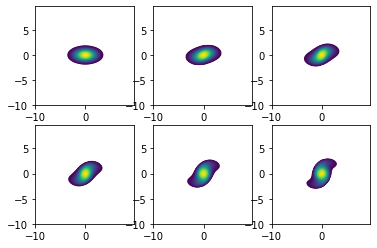

In [9]:
kx = np.zeros(nx)
for i in range(int(nx/2-1)+1):
    kx[i] = i
    kx[int(nx/2-1)+i+1] = -int(nx/2-1)+i-1
kx = kx* 2*np.pi/Lx
kx[0] = 10**(-6)
ky = np.zeros(ny)
for i in range(int(ny/2-1)+1):
    ky[i] = i
    ky[int(ny/2-1)+i+1] = -int(ny/2-1)+i-1
ky = ky* 2*np.pi/Ly
ky[0] = 10**(-6)
KX = np.zeros((64,64))
[KX,KY]=np.meshgrid(kx,ky);
KX = KX.T
KY = KY.T
K=KX**2+KY**2;

wt =fft2(w)
wt2 = wt.real
wt2 = wt2.reshape((len(wt)*len(wt)))

def spc_rhs(t,wt2):
    wtt = wt2.reshape(len(wt)*len(wt),1,order='F')
    wtt = wt2.reshape(64,64)
    
    psit = -wtt/K
    
    psix = (ifft2(1j*KX*psit)).real
    psiy = (ifft2(1j*KY*psit)).real 
    
    wx = (ifft2(1j*KX*wtt)).real
    wy = (ifft2(1j*KY*wtt)).real
    rhs = -nu*K*wtt+fft2(wx*psiy-wy*psix)
    rhs =  rhs.reshape(N)
    return rhs

sol = solve_ivp (spc_rhs,[0,10], wt2, t_eval=[0, 2, 4, 6, 8,10] )

T = sol.t
F = sol.y

levels = np.linspace(0.05,1,100)
for j in range(len(tspan)):
    plt.subplot(2,3,j+1)
    wf = ifft2(F[:,j].reshape(nx,ny)).real
    CS = plt.contour(X, Y, wf, levels)   # set levels automatically
  #  plt.title(j)
   # plt.colorbar()

The code results show the behavior of the vorticity. The stretched Gaussian is seen to rotate while advecting and diffusing vorticity. And we can find the FFT result, and iterative method result is same.